## Test sparsification of graphs


In [2]:
import os.path
import platform
import unittest
import os
import glob

import matplotlib.pyplot as plt
from dendropy.interop import raxml
from dendropy.model.discrete import simulate_discrete_chars, Jc69
from dendropy.calculate.treecompare import symmetric_difference
from numpy.random import default_rng
import time
import numpy as np
import shutil
import pandas as pd
import spectraltree
import scipy
# import toytree
# import toyplot
# import toyplot.svg
# from svglib.svglib import svg2rlg
# from reportlab.graphics import renderPDF


In [17]:
l = 4
mu = 0.04
m = 512
P = (1-mu)*np.eye(l)+(np.ones(l)-np.eye(l))*(mu/(l-1))
print(P)
print(np.linalg.det(P))
delta = (1-mu*(l)/(l-1))**(l-1)
print(delta)
print(delta**(2*np.log2(m)-3))


[[0.96       0.01333333 0.01333333 0.01333333]
 [0.01333333 0.96       0.01333333 0.01333333]
 [0.01333333 0.01333333 0.96       0.01333333]
 [0.01333333 0.01333333 0.01333333 0.96      ]]
0.8483816296296295
0.8483816296296296
0.08489240547351137


In [20]:
def check_is_bipartition(tree, partition_mask, meta):
    return (meta.mask2bipartition(partition_mask).split_bitmask in tree.split_bitmask_edge_map) or \
            (meta.mask2bipartition(~partition_mask).split_bitmask in tree.split_bitmask_edge_map)


In [ ]:
def compute_similarity_matrix(tree):
    a = 1
    

In [6]:
def read_tree(tree):
    tree.write(path="output.tre", schema="newick")
    tre0 = toytree.tree("output.tre", tree_format=0)
    return tre0

def generate_tree_figure(tree,spdata,width,height,tip_labels,filename):

    # switch data for figure
    tre0 = read_tree(tree)

    n_col = spdata.shape[1]
    ctree = tre0.mod.node_scale_root_height(spdata.shape[1] * 2)
    # get canvas and axes with tree plot
    canvas, axes, mark = ctree.draw(width=width, height=height, tip_labels_align=True, tip_labels=tip_labels, tip_labels_style={"-toyplot-anchor-shift": "800px"});
    xoffset = 0.5 
    for col in range(n_col):

        # select the column of data
        data = spdata[:, col]
        u_d = np.sort(np.unique(data))
        
        print(u_d)
        data_sorted = np.zeros(data.shape)
        ctr = 1
        for i in range(len(u_d)):
            if u_d[i]!=0:
                data_sorted[data==u_d[i]]=ctr
                ctr = ctr+1
        data = data_sorted
        # plot the data column
        if col==4:
            xoffset = 1
        axes.scatterplot(np.repeat(0.5*col, tre0.ntips) + xoffset,np.arange(tre0.ntips), marker='s',
        size=15, 
        color=toytree.colors[col],
        #color=toytree.colors[0], 
        opacity=0.1 + data[::-1] / data.max(), title=data,
    );

    # stretch domain to fit long tip names
    axes.x.domain.max = 20

    toyplot.svg.render(canvas, filename+'.svg')
    drawing = svg2rlg(filename + '.svg')
    renderPDF.drawToFile(drawing, filename+'.pdf')




smallest value of S is  [0.032768   0.032768   0.01896296 0.032768  ]
th 0.0  - Percent of zeroed out: 0.0
th 0.05  - Percent of zeroed out: 0.32826995849609375
th 0.1  - Percent of zeroed out: 0.720703125
th 0.15000000000000002  - Percent of zeroed out: 0.8758621215820312
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27]
[15530 30134 14343  4177  1144   196    10     1     1]


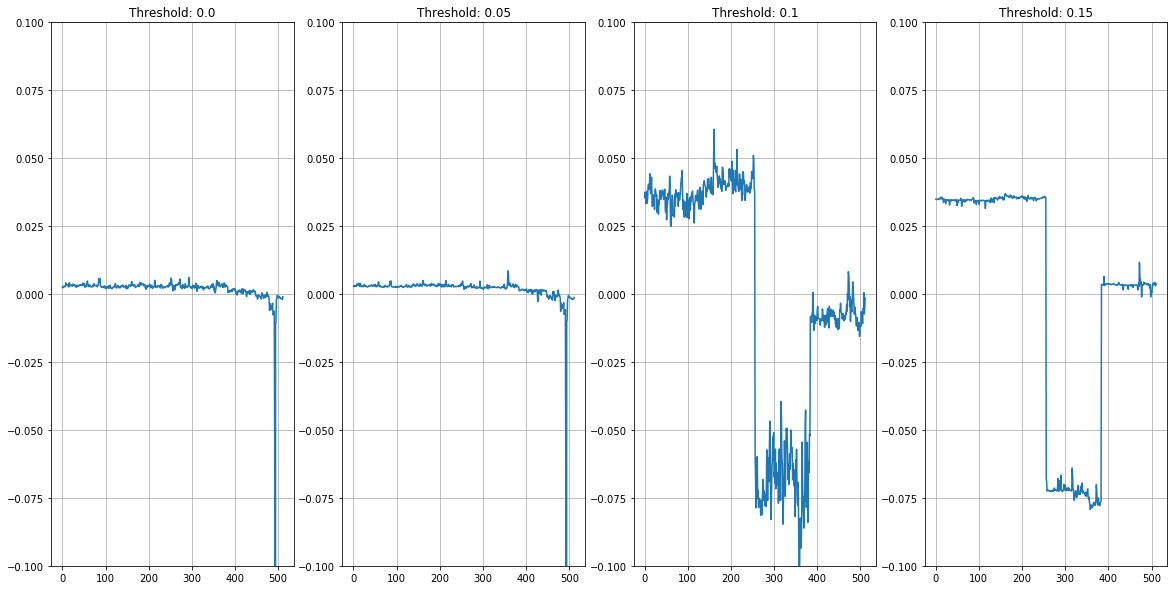

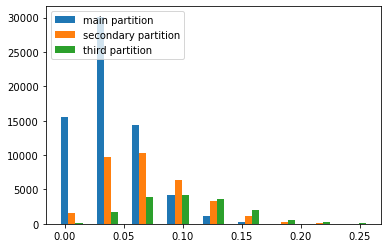

In [4]:
# view several examples of eigenvectors
n = 100
num_taxa = 512
error_rate = 0.04

th_vec = np.arange(0,0.20,0.05)
num_itr = 50
jc = spectraltree.Jukes_Cantor() 
mutation_rate = jc.p2t(1-error_rate)
reference_tree = spectraltree.balanced_binary(num_taxa)
observations, taxa_meta = spectraltree.simulate_sequences(n, tree_model=reference_tree, seq_model=jc, mutation_rate=mutation_rate, alphabet="DNA")
S = spectraltree.JC_similarity_matrix(observations)
print('smallest value of S is ',S[0,256:260])
v_s_mtx = np.zeros((num_taxa,len(th_vec)))
for th_idx,th in enumerate(th_vec):  
        num_of_zeroed_out = sum(sum((S>th)))
        perccent_of_zeroed_out = 1 - num_of_zeroed_out/S.size
        print("th", th, " - Percent of zeroed out:", perccent_of_zeroed_out)      
        #print(sum(np.reshape(S,-1)<th))        
        S_sparse = S*(S>th)
        w_s,v_s = np.linalg.eigh(np.diag(np.sum(S_sparse,axis=1)) - S_sparse)
        v_s_mtx[:,th_idx] = v_s[:,1]

fig,axes = plt.subplots(1,4,figsize = (20,10))
for i, ax in enumerate(axes.flat):
        ax.plot(v_s_mtx[:,i])
        ax.set_ylim([-0.1,0.1])
        ax.title.set_text('Threshold: '+str(float("{0:.2f}".format(th_vec[i]))))
        ax.grid()
fig.savefig('eigenvectors_threshold.pdf')

S_vec = S[int(num_taxa/2):,:int(num_taxa/2)].flatten()
S_vec_b = np.concatenate((S[:int(num_taxa/4),int(num_taxa/4):int(num_taxa/2)],S[int(num_taxa/2):int(3*num_taxa/4),int(3*num_taxa/4):])).flatten()

S_vec_c = np.concatenate((S[:int(num_taxa/8),int(num_taxa/8):int(num_taxa/4)],S[int(num_taxa/4):int(3*num_taxa/8),int(3*num_taxa/8):int(num_taxa/2)]))
S_vec_c = np.concatenate((S_vec_c,S[int(num_taxa/2):int(5*num_taxa/8),int(5*num_taxa/8):int(3*num_taxa/4)]))
S_vec_c = np.concatenate((S_vec_c,S[int(3*num_taxa/4):int(7*num_taxa/8),int(7*num_taxa/8):])).flatten()

barwidth = 0.006
x_label = np.arange(0,0.3,0.03)
print(x_label)
y_hist_main,bin = np.histogram(S_vec,x_label)
y_hist_Sec,bin = np.histogram(S_vec_b,x_label)
y_hist_third,bin = np.histogram(S_vec_c,x_label)
x_label = x_label[0:-1]
print(y_hist_main)
fig = plt.figure()
plt.bar(x_label,y_hist_main,barwidth)
plt.bar(x_label+barwidth,y_hist_Sec,barwidth)
plt.bar(x_label+2*barwidth,y_hist_third,barwidth)
plt.legend(['main partition','secondary partition','third partition'],loc=2)
fig.savefig('histogram_threshold.pdf')

        #plt.legend()

In [198]:
mu = 0.04
delta = (1-(4/3)*0.04)**3
P = (1-mu)*np.eye(4)+ (mu/3)*(np.ones(4)-np.eye(4))
#print(P)
print(delta)
print(np.linalg.det(P))
print(delta**(2*np.log2(512)-1))

0.8483816296296296
0.8483816296296295
0.061101426796965175


In [32]:
n = 100
num_taxa = 512
error_rate = 0.04
th_vec = np.arange(0,0.2,0.01)
num_itr = 100
jc = spectraltree.Jukes_Cantor() 
mutation_rate = jc.p2t(1-error_rate)
reference_tree = spectraltree.balanced_binary(num_taxa)
#reference_tree = spectraltree.unrooted_pure_kingman_tree(num_taxa)
res = np.zeros((num_itr,len(th_vec)))
res_sparse = np.zeros((num_itr,len(th_vec)))
#stdr_nj = spectraltree.STDR(spectraltree.NeighborJoining,spectraltree.JC_similarity_matrix,similarity_threshold=0) 
cor_sparse = np.zeros((num_itr,len(th_vec)))
m_half = int(num_taxa/2)
balanced_vector = np.concatenate((np.ones(m_half),np.zeros(m_half)))
for itr in range(num_itr):
    #print(itr)
    observations, taxa_meta = spectraltree.simulate_sequences(n, tree_model=reference_tree, seq_model=jc, mutation_rate=mutation_rate, alphabet="DNA")
    for th_idx,th in enumerate(th_vec):
        S = spectraltree.JC_similarity_matrix(observations)
        #print(sum(np.reshape(S,-1)<th))        
        S_sparse = S*(S>th)
        #print(np.linalg.norm(S_sparse-S))
        #S_sparse[S<th]=0
        #w,v = np.linalg.eigh(np.diag(np.sum(S,axis=1)) - S)
        #cor_non_sparse[itr,th_idx] = np.sum(balanced_vector==np.ceil(v[:,1]))
        

        w_s,v_s = np.linalg.eigh(np.diag(np.sum(S_sparse,axis=1)) - S_sparse)
        #partition_size[itr,th_idx] = np.sum(v_s[:,1]>0)
        #res[itr,n_idx] = check_is_bipartition(reference_tree,v[:,1]>0, taxa_meta)
        res_sparse[itr,th_idx] = check_is_bipartition(reference_tree,v_s[:,1]>0, taxa_meta)
        
        cor_sparse[itr,th_idx] = np.sum(balanced_vector==np.ceil(v_s[:,1]))
        

        #plt.imshow(S)
cor_sparse = np.maximum(cor_sparse,num_taxa-cor_sparse)

#print('results non sparse matrix: ', np.mean(res,axis = 0))
print('results sparse matrix: ', np.mean(cor_sparse,axis = 0))

results sparse matrix:  [407.06 406.33 403.03 401.11 400.95 401.97 409.06 418.41 443.73 449.94
 453.57 455.75 461.16 460.08 459.39 455.09 450.1  452.1  444.11 428.27]


(20,)
(20,)
(15,)


<Figure size 432x288 with 0 Axes>

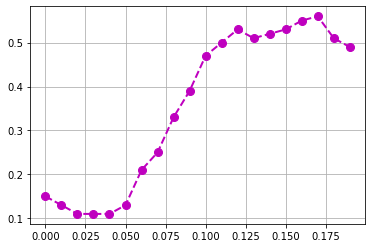

In [35]:
fig = plt.figure()
y1 = np.mean(cor_sparse,axis = 0)
v1 = np.std(cor_sparse,axis = 0)
print(v1.shape)
y2 = np.mean(cor_sparse==512,axis = 0)
print(th_vec.shape)
print(y.shape)
#plt.errorbar(th_vec,y1,v1,linewidth=2, markersize=12)
fig = plt.figure()
plt.plot(th_vec,y2,'mo--', linewidth=2, markersize=8)
plt.grid()
fig.savefig('threshold_results_binary.pdf')


In [9]:

n = 10**3
num_taxa = 1000
error_rate = 0.02
th_vec = np.arange(0,0.2,0.01)
num_itr = 100
jc = spectraltree.Jukes_Cantor() 
mutation_rate = jc.p2t(1-error_rate)
reference_tree = spectraltree.unrooted_birth_death_tree(num_taxa)
observations, taxa_meta = spectraltree.simulate_sequences(n, tree_model=reference_tree, seq_model=jc, mutation_rate=mutation_rate, alphabet="DNA")
S = spectraltree.JC_similarity_matrix(observations)
L = np.diag(np.sum(S,axis = 1))-S
d,v = np.linalg.eigh(L)
fig = plt.figure()
spdata = np.flipud(np.ceil(v[:,1:4]))
generate_tree_figure(reference_tree,spdata,4000,2400,False,'birth_death_example')
S_vec = S.flatten()
y = np.histogram(S_vec,bins  = 30)
#plt.imshow(S)
#plt.colorbar()




[-0.  1.]
[-0.  1.]
[-0.  1.]


<Figure size 432x288 with 0 Axes>

In [17]:
spdata = np.flipud(spdata)
generate_tree_figure(reference_tree,spdata,4000,2400,False,'birth_death_example')

[-0.  1.]
[-0.  1.]
[-0.  1.]


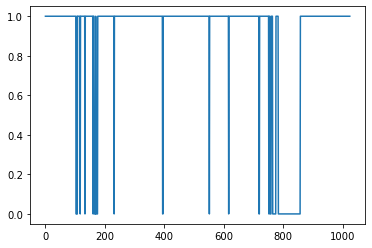

In [15]:
plt.plot(spdata[:,2])

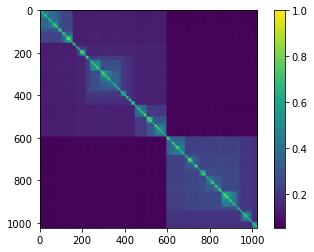

In [49]:
fig = plt.figure()
plt.imshow(S)
plt.colorbar()
fig.savefig('similarity_matrix_birth_death.pdf')

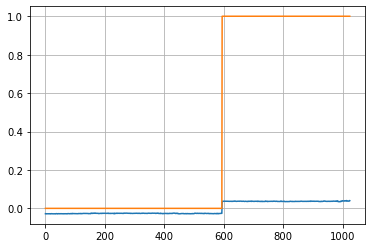

In [52]:
L = np.diag(np.sum(S,axis = 1))-S
d,v = np.linalg.eigh(L)
fig = plt.figure()
plt.plot(v[:,1])
plt.grid()
#fig.savefig('fiedler_birth_death.pdf')
plt.plot(np.ceil(v[:,1]))

In [55]:
#reference_tree = spectraltree.unrooted_pure_kingman_tree(num_taxa)
n = 100
th_vec = np.arange(0,0.3,0.02)
num_itr = 100
res_sparse = np.zeros((num_itr,len(th_vec)))
#stdr_nj = spectraltree.STDR(spectraltree.NeighborJoining,spectraltree.JC_similarity_matrix,similarity_threshold=0) 
cor_sparse = np.zeros((num_itr,len(th_vec)))
balanced_vector = np.ceil(v[:,1])
for itr in range(num_itr):
    #print(itr) 
    observations, taxa_meta = spectraltree.simulate_sequences(n, tree_model=reference_tree, seq_model=jc, mutation_rate=mutation_rate, alphabet="DNA")
    for th_idx,th in enumerate(th_vec):
        S = spectraltree.JC_similarity_matrix(observations)
        #print(sum(np.reshape(S,-1)<th))        
        S_sparse = S*(S>th)
        #print(np.linalg.norm(S_sparse-S))
        #S_sparse[S<th]=0
        #w,v = np.linalg.eigh(np.diag(np.sum(S,axis=1)) - S)
        #cor_non_sparse[itr,th_idx] = np.sum(balanced_vector==np.ceil(v[:,1]))
        

        w_s,v_s = np.linalg.eigh(np.diag(np.sum(S_sparse,axis=1)) - S_sparse)
        #partition_size[itr,th_idx] = np.sum(v_s[:,1]>0)
        #res[itr,n_idx] = check_is_bipartition(reference_tree,v[:,1]>0, taxa_meta)
        res_sparse[itr,th_idx] = check_is_bipartition(reference_tree,v_s[:,1]>0, taxa_meta)
        
        cor_sparse[itr,th_idx] = np.sum(balanced_vector==np.ceil(v_s[:,1]))
        

        #plt.imshow(S)
cor_sparse = np.maximum(cor_sparse,num_taxa-cor_sparse)

#print('results non sparse matrix: ', np.mean(res,axis = 0))
print('results sparse matrix: ', np.mean(cor_sparse==num_taxa,axis = 0))

results sparse matrix:  [0.6 0.6 0.7 0.6 0.6 0.6 0.7 0.8 0.8 0.8]
